In [1]:
%pylab inline
import cv2

Populating the interactive namespace from numpy and matplotlib


# Segmentación de Imágenes Usando la Transformada Watershed

La *Transformada Watershed* es un algortimo que permite realizar segmentación de imágenes. Así como el algoritmo Canny que trabajamos la clase pasada, es un paso preliminar a la aplicación de la transformada de Hough para la parametrización de los segmentos identificados.  

En la sección 11.5 del libro Digital Image Processing using Matlab de Gonzalez, Woods y Eddings que les subí a Sicua+ (les subí la versión de una versión más actual que la que había subido el lunes) encuentran una descripción del método y cómo implementarlo en Matlab. El objetivo de este taller es familiarizarse con algunos de los algoritmos de procesamiento de imágenes que permiten segmentar y parametrizar características de imágenes con el fin de desarrollar un método de granulometría de metales.  

Con el fin de satisfacer los objetivos planteados se le pide:  

* Leer el archivo de granulometría que va a analizar.  
* Reproducir el resultado mostrado en la Figura 11.28 de la referencia utilizando la herramienta OpenCV. Para esto se recomienda inicialmente revisar y reproducir:  
    * https://stackoverflow.com/questions/11294859/how-to-define-the-markers-for-watershed-in-opencv  
    * https://docs.opencv.org/3.3.1/d3/db4/tutorial_py_watershed.html  
* Ajustar el procedimiento para que segmente eficientemente las imágenes de granulometría.  
* Aplicar la transformada de Hough para parametrizar los segmentos identificados. Para esto se recomienda probar con círculos o elípses para determinar cuál tiene un mejor rendimiento.  
* Extraer la distribución de diámetros de los granos identificados.  
* Generar un histograma de la distribución de tamaño de grano encontrado.  

# Segmentacion 
Primero se debe leer la imagen y binarizarla ya es nesario crear un gradiente que permita la segmentacion por watershed. A continuación se observa la imagen d los granos segmentados. Esta imagen es en blanco y negro. Adicionalmente se observa que existen ciertos puntos blanco solitarios y tambien unos puntos negros. Estos posiblemente son ruido o generado por el threshold. Por eso se decide hacer ciertas transformaciones morfologicas. 

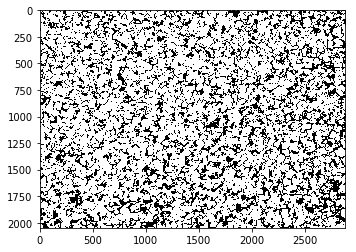

In [2]:
imgOrg=cv2.imread('200x_1010_T.tif')
imgOrg=cv2.cvtColor(imgOrg,cv2.COLOR_RGB2GRAY)
plt.imshow(imgOrg,'gray')
ret,thresh1=cv2.threshold(imgOrg,170,255,cv2.THRESH_BINARY)
plt.imshow(thresh1,'gray')
plt.show()

A continuación se genera un kernel de 30 por 30 con 1. Este se hace para luego hacer una apertura. La apertura es la combinacion de una dlitatacion y una a erosion. En general lo que intenta hacer esta operacion morfologica es borrar detalles pequeños mientras que se mantiene la forma de los detalles grandes. La figura que se muestra despues de esta parte del codigo muestra puntos que se sabe con certeza que eran puntos claros en la imagen original. 

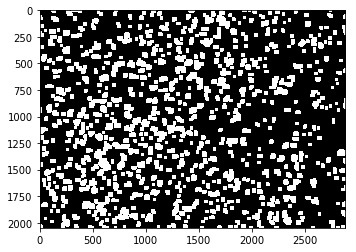

In [3]:
kernel = np.ones((30,30),np.uint8)
opening = cv2.morphologyEx(thresh1, cv2.MORPH_OPEN, kernel)
plt.imshow(opening,'gray')

Luego es importante identificar que es el fondo. Para esto se dilata la imagen anterior con el fin de hacer el foreground un poco más grande. Estos pixeles que se agregan son partes que posiblemente son parte del grano pero que tambien pueden ser parte del fondo. Finalmente se le encuentra la distancia de un punto negro en cada pixel blanco. Esta va a ser el gradiente que se usara para watershed. Finalmente se escoge un threshhold para definir a partir de que distancia del fondo se sabe que es grano. Este parametro es de gran importancia ya que estos son los puntos en los cuales inicia el watershed.

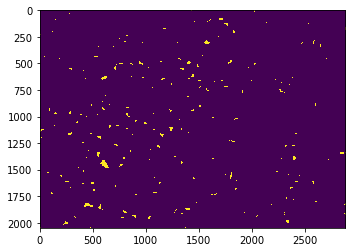

In [4]:
#sure background
surebg=cv2.dilate(opening,kernel,iterations=1)
#
dist=cv2.distanceTransform(opening,cv2.DIST_L2,3)
ret2,surefg=cv2.threshold(dist,.5*dist.max(),255,cv2.THRESH_BINARY)
plt.imshow(surefg)
plt.show()

En este punt se inicia el Watershed primero se encuentran los minimos que estan en la misma sección para ponerle los mismos labels y luego se hace el watershed. El resultado de este se ve en la primera image(cada color es un grano). Es importante notar que no se cogen todos los granos. Esto es por el threshhold anteriormente escogidos. No obstante no se escoge un threshold más pequeño porque o si no empiezan a aparecer puntos de cosas que no son granos. Es decir los granos se empiezan a dividir. Cuando esto pasa no es posible tener una medición correcta del tamaño de grano. En la siguiente imagen se observa el fondo de rojo y algunos de los granos (no todos para poder observar el tamaño que tienen y asi juzgar si es o no un tamaño razonable). En este caso el tamaño de grano si es razonable segun lo que se esperaba. Esto se puedo confirmar con la tercer imagen en la cual se resaltaron los granos sobre los colores de la imagen original. 

298


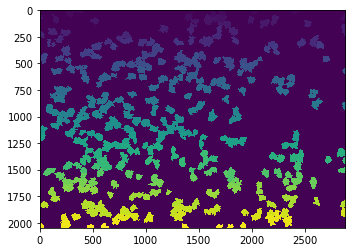

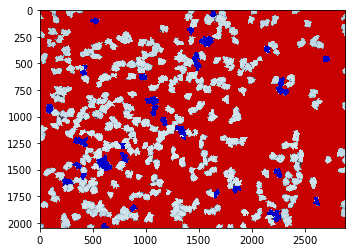

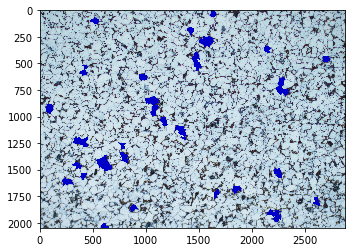

In [5]:
surefg=np.uint8(surefg)
unknown=cv2.subtract(surebg,surefg)

ret,markers=cv2.connectedComponents(surefg)

markers=markers+1
print(markers.max())
markers[unknown==255]=0
markers=markers.astype('int32')


im=cv2.imread('200x_1010_T.tif')
m=cv2.watershed(im,markers)
plt.imshow(m)
plt.show()

im2=im.copy()
im2[m==1]=(200,0,0)
im2[m%9==0]=(0,0,200)
plt.imshow(im2)
plt.show()

im3=im.copy()
im3[m%9==0]=(0,0,200)
plt.imshow(im3)
plt.show()

A continuación se cuentan cuantos pixeles hay en cada grano. Esto se hace con el fin de obtener una medida del tamaño del grano. Se decidio no medir el radio ya que estos granos no son circulares. 

In [6]:
tams=np.zeros(m.max())
la=tams.copy()
for l in range(1,m.max()):
    labs=m==l+1
    tams[l]=np.count_nonzero(labs)
#el label 1 es el fondo por eso se quita    
tams=tams[1:]
#Se quitan todos los labels que no tengan pixeles (esto ocurre
#Porque en el proceso de conectar los marcadores algunos labels se juntan.)
tams=tams[tams!=0]

Una vez se tiene el tamaño de grano es posible hacer un histograma para identificar el tamaño promedio y como se distribuyen.Como se observa el tamaño promedio de grano es de 3280.7 pixeles. 

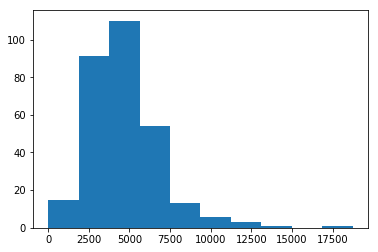

4681.265306122449


In [7]:
plt.hist(tams)
plt.show()
print(mean(tams))

A continuacion se quiere estudiar como el threshhold de la distancia afecta el tamaño de grano y el numero de granos encontrados. 

In [8]:
im=cv2.imread('200x_1010_T.tif')
dist=cv2.distanceTransform(opening,cv2.DIST_L2,3)

ts=[.2,.3,.4,.5,.6,.7,.8]
promedios=[]
numgranos=[]
for t in ts:
    ret2,surefg=cv2.threshold(dist,t*dist.max(),255,cv2.THRESH_BINARY)
    surefg=np.uint8(surefg)
    unknown=cv2.subtract(surebg,surefg)

    ret,markers=cv2.connectedComponents(surefg)

    markers=markers+1

    markers[unknown==255]=0
    markers=markers.astype('int32')
    m=cv2.watershed(im,markers)

    tams=np.zeros(m.max())
    la=tams.copy()
    for l in range(1,m.max()):
        labs=m==l+1
        tams[l]=np.count_nonzero(labs)
    #el label 1 es el fondo por eso se quita    
    tams=tams[1:]
    #Se quitan todos los labels que no tengan pixeles (esto ocurre
    #Porque en el proceso de conectar los marcadores algunos labels se juntan.)
    tams=tams[tams!=0]
    promedios.append(mean(tams))
    numgranos.append(len(tams))




A continuación es posible observar el resultado de este estudio. Se observa que hay una correlacion clara entre el tamaño de grano y este parametro. Lo mismo ocurre con el numero de granos encontrados. Es por esto que se puede concluir que el presente algorithmo funciona como una implmentacion inicial de la medicion de tamaño de grano no obstante es importante tener una seleccion posterior de todos los parametros. Adicionalmente se recomienda preprocesamiento de las imagenes mas extensa que permita mejor segmentación de los granos.  Estas dos recomendaciones requieren de una base de datos mayores para entrenamiento y de prueba. Con el fin de evaluar la eficacia de cada uno de los parametros. La eficacia entendiendose como la precision y la exactitud del programa en el momento de segmentar la imagen. 

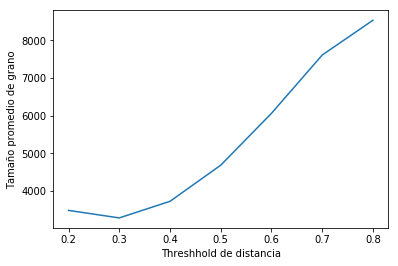

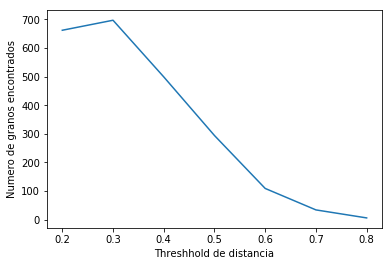

In [9]:
plt.plot(ts,promedios)
plt.xlabel('Threshhold de distancia')
plt.ylabel('Tamaño promedio de grano')
plt.show()

plt.plot(ts,numgranos)
plt.xlabel('Threshhold de distancia')
plt.ylabel('Numero de granos encontrados')
plt.show()
